Two Sigma Financial Modeling Challenge
Can you uncover predictive value in an uncertain world?

Submissions will be evaluated on the R value between the predicted and actual values.

In [1]:
import numpy as np 
import pandas as pd 
from scipy import signal
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# load the dataset
with pd.HDFStore("./data/train.h5", "r") as train:
    df = train.get("train")

This dataset contains anonymized features pertaining to a time-varying value for a financial instrument. 
Each instrument has an id. 
Time is represented by the 'timestamp' feature and the variable to predict is 'y'. 

No further information will be provided on the meaning of the features, the transformations that were applied to them, the timescale, or the type of instruments that are included in the data. Moreover, in accordance with competition rules, participants must not use data other than the data linked from the competition website for the purpose of use in this competition to develop and test their models and submissions.

Data is saved and accessed as a .h5 file in the Kernels environment. We have used the .h5 file format instead of the standard .csv format to achieve faster read speeds. The training set file is available for download and offline modeling outside of Kernels. The test set is not available for download.

The API also provides a "reward" for each timestamp, in the form of an average R value over the predicted values for the previous day. You may choose to use this reward to do reinforcement-style learning. Your code should expect and handle missing values.

We have setup the kernels environment such that the code structure you use for training on the test set (clicking "Run") will ideally work for submissions on the test set (clicking "Submit"). To achieve this, we have partitioned the training set such that the first half is provided as a training set at the start of a run, and the latter half is streamed through the API, as though it is a holdout set. In other words:

Run: first half of training set (split by time) provided initially, second half of training set used for API/predictions.
Submit: all of training set provided initially, test set used for API/predictions.

In [3]:
df.head()

,id,timestamp,derived_0,derived_1,derived_2,derived_3,derived_4,fundamental_0,fundamental_1,fundamental_2,...,technical_36,technical_37,technical_38,technical_39,technical_40,technical_41,technical_42,technical_43,technical_44,y
0,10,0,0.370326,-0.006316,0.222831,-0.213030,0.729277,-0.335633,0.113292,1.621238,...,0.775208,NaN,NaN,NaN,-0.414776,NaN,NaN,-2.0,NaN,-0.011753
1,11,0,0.014765,-0.038064,-0.017425,0.320652,-0.034134,0.004413,0.114285,-0.210185,...,0.025590,NaN,NaN,NaN,-0.273607,NaN,NaN,-2.0,NaN,-0.001240
2,12,0,-0.010622,-0.050577,3.379575,-0.157525,-0.068550,-0.155937,1.219439,-0.764516,...,0.151881,NaN,NaN,NaN,-0.175710,NaN,NaN,-2.0,NaN,-0.020940
3,25,0,NaN,NaN,NaN,NaN,NaN,0.178495,NaN,-0.007262,...,1.035936,NaN,NaN,NaN,-0.211506,NaN,NaN,-2.0,NaN,-0.015959
4,26,0,0.176693,-0.025284,-0.057680,0.015100,0.180894,0.139445,-0.125687,-0.018707,...,0.630232,NaN,NaN,NaN,-0.001957,NaN,NaN,0.0,NaN,-0.007338


In [17]:
df.head(50)

,id,timestamp,derived_0,derived_1,derived_2,derived_3,derived_4,fundamental_0,fundamental_1,fundamental_2,...,technical_36,technical_37,technical_38,technical_39,technical_40,technical_41,technical_42,technical_43,technical_44,y
0,10,0,0.370326,-0.006316,0.222831,-0.213030,0.729277,-0.335633,0.113292,1.621238,...,0.775208,NaN,NaN,NaN,-0.414776,NaN,NaN,-2.0,NaN,-0.011753
1,11,0,0.014765,-0.038064,-0.017425,0.320652,-0.034134,0.004413,0.114285,-0.210185,...,0.025590,NaN,NaN,NaN,-0.273607,NaN,NaN,-2.0,NaN,-0.001240
2,12,0,-0.010622,-0.050577,3.379575,-0.157525,-0.068550,-0.155937,1.219439,-0.764516,...,0.151881,NaN,NaN,NaN,-0.175710,NaN,NaN,-2.0,NaN,-0.020940
3,25,0,NaN,NaN,NaN,NaN,NaN,0.178495,NaN,-0.007262,...,1.035936,NaN,NaN,NaN,-0.211506,NaN,NaN,-2.0,NaN,-0.015959
4,26,0,0.176693,-0.025284,-0.057680,0.015100,0.180894,0.139445,-0.125687,-0.018707,...,0.630232,NaN,NaN,NaN,-0.001957,NaN,NaN,0.0,NaN,-0.007338
5,27,0,0.346856,0.166239,-6.080701,-0.992249,-0.125916,0.345812,NaN,-0.584239,...,-0.379366,NaN,NaN,NaN,-0.001957,NaN,NaN,-2.0,NaN,0.031425
6,31,0,0.072036,0.014931,NaN,0.014063,NaN,-0.193205,NaN,NaN,...,1.232558,NaN,NaN,NaN,0.350685,NaN,NaN,-2.0,NaN,-0.032895
7,38,0,0.300062,0.071251,-0.074451,-0.065292,-0.011286,0.026365,0.210249,0.167494,...,0.242646,NaN,NaN,NaN,-0.168077,NaN,NaN,-2.0,NaN,0.015803
8,39,0,-0.003511,-0.034270,0.082372,-0.023937,-0.025750,0.007815,0.263451,-0.241212,...,0.186175,NaN,NaN,NaN,-0.300842,NaN,NaN,-2.0,NaN,-0.027593
9,40,0,-0.083330,0.081935,-2.048438,-0.206856,-0.839563,-0.234100,-0.291853,-5.722336,...,-0.021965,NaN,NaN,NaN,-0.386579,NaN,NaN,-2.0,NaN,0.006662


In [4]:
# classes of cols
list(set([c.split('_')[0] for c in df.columns]))

[u'technical', u'timestamp', u'derived', u'fundamental', u'y', u'id']

In [28]:
fundamental_list=[]
for c in df.columns:
    if c.split('_')[0]=='fundamental':
        fundamental_list.append(c)

for c in fundamental_list:
    print c

fundamental_0
fundamental_1
fundamental_2
fundamental_3
fundamental_5
fundamental_6
fundamental_7
fundamental_8
fundamental_9
fundamental_10
fundamental_11
fundamental_12
fundamental_13
fundamental_14
fundamental_15
fundamental_16
fundamental_17
fundamental_18
fundamental_19
fundamental_20
fundamental_21
fundamental_22
fundamental_23
fundamental_24
fundamental_25
fundamental_26
fundamental_27
fundamental_28
fundamental_29
fundamental_30
fundamental_31
fundamental_32
fundamental_33
fundamental_34
fundamental_35
fundamental_36
fundamental_37
fundamental_38
fundamental_39
fundamental_40
fundamental_41
fundamental_42
fundamental_43
fundamental_44
fundamental_45
fundamental_46
fundamental_47
fundamental_48
fundamental_49
fundamental_50
fundamental_51
fundamental_52
fundamental_53
fundamental_54
fundamental_55
fundamental_56
fundamental_57
fundamental_58
fundamental_59
fundamental_60
fundamental_61
fundamental_62
fundamental_63


In [29]:
technical_list=[]
for c in df.columns:
    if c.split('_')[0]=='technical':
        technical_list.append(c)

for c in technical_list:
    print c

technical_0
technical_1
technical_2
technical_3
technical_5
technical_6
technical_7
technical_9
technical_10
technical_11
technical_12
technical_13
technical_14
technical_16
technical_17
technical_18
technical_19
technical_20
technical_21
technical_22
technical_24
technical_25
technical_27
technical_28
technical_29
technical_30
technical_31
technical_32
technical_33
technical_34
technical_35
technical_36
technical_37
technical_38
technical_39
technical_40
technical_41
technical_42
technical_43
technical_44


In [5]:
#print stats of all columns in the dataset
df.describe()

,id,timestamp,derived_0,derived_1,derived_2,derived_3,derived_4,fundamental_0,fundamental_1,fundamental_2,...,technical_36,technical_37,technical_38,technical_39,technical_40,technical_41,technical_42,technical_43,technical_44,y
count,1.710756e+06,1.710756e+06,1.637797e+06,1.629727e+06,1.312105e+06,1.561285e+06,1.304298e+06,1.686809e+06,1.031686e+06,1.341916e+06,...,1.708204e+06,1.691591e+06,1.691591e+06,1.690740e+06,1.708520e+06,1.666567e+06,1.690755e+06,1.706070e+06,1.473977e+06,1.710756e+06
mean,1.093858e+03,9.456257e+02,-4.536046e+00,7.729436e+11,-3.320328e-01,-5.046012e-01,1.801661e+01,-2.040938e-02,-5.703754e+08,-1.622954e-01,...,-8.584833e-02,-9.103397e-02,-8.156685e-02,-7.287001e-02,4.908321e-02,5.236218e-03,-1.699966e-02,-9.735299e-01,3.881475e-04,2.217509e-04
std,6.308563e+02,5.195685e+02,2.497382e+02,7.620606e+13,6.519810e+01,1.020749e+02,9.258360e+02,2.494859e-01,7.502322e+10,3.668150e+00,...,6.125852e-01,2.471038e-01,2.346534e-01,2.235729e-01,3.102316e-01,1.133733e-01,2.116284e-01,9.605551e-01,3.011983e-02,2.240643e-02
min,0.000000e+00,0.000000e+00,-2.017497e+04,-7.375435e-02,-9.848880e+03,-3.434176e+04,-8.551914e+03,-2.344957e+00,-1.043737e+13,-1.077101e+03,...,-1.687572e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-5.250904e-01,-4.449529e-01,-1.000000e+00,-2.000000e+00,-1.265686e-01,-8.609413e-02
25%,5.500000e+02,5.040000e+02,-1.449710e-01,-2.956479e-02,-5.967524e-02,-1.655826e-01,-1.057050e-01,-1.996543e-01,-1.960470e-01,-2.280967e-01,...,-4.050297e-01,-4.651562e-04,-1.992532e-04,-2.203252e-05,-1.521701e-01,-7.377038e-02,-3.887695e-15,-2.000000e+00,-1.998819e-02,-9.561389e-03
50%,1.098000e+03,9.560000e+02,-8.368272e-04,5.523058e-03,2.109505e-02,2.475614e-03,1.175234e-02,-4.064488e-02,-7.395084e-03,-3.029069e-02,...,-8.502064e-02,-3.951567e-12,-1.418487e-13,-1.591224e-16,-1.476793e-02,9.782702e-05,0.000000e+00,-6.597540e-01,1.117279e-05,-1.570681e-04
75%,1.657000e+03,1.401000e+03,1.199108e-01,1.078554e-01,1.952209e-01,3.037236e-01,1.556464e-01,1.303819e-01,1.832071e-01,1.764751e-01,...,1.909600e-01,-5.219879e-40,0.000000e+00,0.000000e+00,1.772415e-01,7.855728e-02,0.000000e+00,-5.188884e-08,2.047074e-02,9.520990e-03
max,2.158000e+03,1.812000e+03,3.252527e+03,1.068448e+16,3.823001e+03,1.239737e+03,6.785965e+04,1.378195e+00,5.203165e+02,7.677125e+01,...,4.957758e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.569265e+00,6.844833e-01,1.000000e+00,0.000000e+00,1.435858e-01,9.349781e-02


In [ ]:
# Produce a scatter matrix for each pair of features in the data
# pd.scatter_matrix(df, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

In [7]:
#get info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1710756 entries, 0 to 1710755
Columns: 111 entries, id to y
dtypes: float32(109), int16(2)
memory usage: 730.9 MB


In [13]:
#get info on missing data
df.isnull().sum()

id                     0
timestamp              0
derived_0          72959
derived_1          81029
derived_2         398651
derived_3         149471
derived_4         406458
fundamental_0      23947
fundamental_1     679070
fundamental_2     368840
fundamental_3     454380
fundamental_5     962020
fundamental_6     701625
fundamental_7      26340
fundamental_8     373166
fundamental_9     565567
fundamental_10    112977
fundamental_11    368840
fundamental_12    110871
fundamental_13    355138
fundamental_14    356084
fundamental_15    354897
fundamental_16    355138
fundamental_17     97222
fundamental_18     15833
fundamental_19     54588
fundamental_20    110871
fundamental_21     54333
fundamental_22    558488
fundamental_23    356723
                   ...  
technical_13        4764
technical_14       14184
technical_16       19981
technical_17        4279
technical_18       20016
technical_19        2320
technical_20        4764
technical_21        2236
technical_22           0


In [20]:
#length of df:1710756
num_df=len(df)
#print columns with more than 20% missing data
df.isnull().sum()[df.isnull().sum()>=len(df)/5]

derived_2         398651
derived_4         406458
fundamental_1     679070
fundamental_2     368840
fundamental_3     454380
fundamental_5     962020
fundamental_6     701625
fundamental_8     373166
fundamental_9     565567
fundamental_11    368840
fundamental_13    355138
fundamental_14    356084
fundamental_15    354897
fundamental_16    355138
fundamental_22    558488
fundamental_23    356723
fundamental_24    576655
fundamental_26    657184
fundamental_28    667331
fundamental_29    354106
fundamental_30    354907
fundamental_31    454380
fundamental_34    434862
fundamental_35    424476
fundamental_37    355843
fundamental_38    803489
fundamental_39    377574
fundamental_43    354531
fundamental_44    355805
fundamental_46    355843
fundamental_47    446328
fundamental_49    558333
fundamental_50    355231
fundamental_51    447053
fundamental_54    384213
fundamental_55    368840
fundamental_56    368840
fundamental_57    657184
fundamental_60    355126
fundamental_61    671801


In [26]:
for col in df.isnull().sum()[df.isnull().sum()>=len(df)/5]:
    print float(col)/(len(df))

0.233026217649
0.237589697187
0.396941469152
0.215600588278
0.265601874259
0.562336183535
0.410125698814
0.218129294885
0.330594777981
0.215600588278
0.207591263745
0.208144235648
0.207450390354
0.207591263745
0.326456841303
0.208517754724
0.337076123071
0.384148294672
0.390079590544
0.20698802167
0.207456235723
0.265601874259
0.254192883146
0.248121882957
0.208003362256
0.469668965066
0.220705933517
0.20723644985
0.207981149854
0.208003362256
0.260895183182
0.326366238084
0.207645625677
0.261318972431
0.224586673962
0.215600588278
0.215600588278
0.384148294672
0.207584249303
0.392692470463
0.219560241203


In [ ]:
# to be researched further
# is there seasonality in missing fundamental data
# if yes, then reuse value from previous timestamp


In [30]:
df_null_info=df.isnull().sum()
df_null_info[df_null_info==0]

id              0
timestamp       0
technical_22    0
technical_34    0
y               0
dtype: int64

In [31]:
df_null_info['fundamental_0']

23947

In [33]:
mycols=[]
#remove columns with more than 20% missing data
for c in df.columns:
    if df_null_info[c]>len(df)*0.2:
        pass
    else:
        mycols.append(c)

for c in mycols:
    print c

id
timestamp
derived_0
derived_1
derived_3
fundamental_0
fundamental_7
fundamental_10
fundamental_12
fundamental_17
fundamental_18
fundamental_19
fundamental_20
fundamental_21
fundamental_25
fundamental_27
fundamental_32
fundamental_33
fundamental_36
fundamental_40
fundamental_41
fundamental_42
fundamental_45
fundamental_48
fundamental_52
fundamental_53
fundamental_58
fundamental_59
fundamental_62
technical_0
technical_1
technical_2
technical_3
technical_5
technical_6
technical_7
technical_9
technical_10
technical_11
technical_12
technical_13
technical_14
technical_16
technical_17
technical_18
technical_19
technical_20
technical_21
technical_22
technical_24
technical_25
technical_27
technical_28
technical_29
technical_30
technical_31
technical_32
technical_33
technical_34
technical_35
technical_36
technical_37
technical_38
technical_39
technical_40
technical_41
technical_42
technical_43
technical_44
y


In [34]:
#drop cols not in mycols
df=df[mycols]

In [35]:
df.describe()

,id,timestamp,derived_0,derived_1,derived_3,fundamental_0,fundamental_7,fundamental_10,fundamental_12,fundamental_17,...,technical_36,technical_37,technical_38,technical_39,technical_40,technical_41,technical_42,technical_43,technical_44,y
count,1.710756e+06,1.710756e+06,1.637797e+06,1.629727e+06,1.561285e+06,1.686809e+06,1.684416e+06,1.597779e+06,1.599885e+06,1.613534e+06,...,1.708204e+06,1.691591e+06,1.691591e+06,1.690740e+06,1.708520e+06,1.666567e+06,1.690755e+06,1.706070e+06,1.473977e+06,1.710756e+06
mean,1.093858e+03,9.456257e+02,-4.536046e+00,7.729436e+11,-5.046012e-01,-2.040938e-02,4.865615e+01,4.418401e-01,6.168341e+01,7.087444e+13,...,-8.584833e-02,-9.103397e-02,-8.156685e-02,-7.287001e-02,4.908321e-02,5.236218e-03,-1.699966e-02,-9.735299e-01,3.881475e-04,2.217509e-04
std,6.308563e+02,5.195685e+02,2.497382e+02,7.620606e+13,1.020749e+02,2.494859e-01,4.763797e+03,4.330144e+00,2.152291e+03,8.059463e+15,...,6.125852e-01,2.471038e-01,2.346534e-01,2.235729e-01,3.102316e-01,1.133733e-01,2.116284e-01,9.605551e-01,3.011983e-02,2.240643e-02
min,0.000000e+00,0.000000e+00,-2.017497e+04,-7.375435e-02,-3.434176e+04,-2.344957e+00,-3.390085e-01,-8.453134e-02,-3.446150e-02,-3.636979e+16,...,-1.687572e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-5.250904e-01,-4.449529e-01,-1.000000e+00,-2.000000e+00,-1.265686e-01,-8.609413e-02
25%,5.500000e+02,5.040000e+02,-1.449710e-01,-2.956479e-02,-1.655826e-01,-1.996543e-01,-1.182689e-01,-3.655409e-02,-2.417559e-02,-2.591163e-01,...,-4.050297e-01,-4.651562e-04,-1.992532e-04,-2.203252e-05,-1.521701e-01,-7.377038e-02,-3.887695e-15,-2.000000e+00,-1.998819e-02,-9.561389e-03
50%,1.098000e+03,9.560000e+02,-8.368272e-04,5.523058e-03,2.475614e-03,-4.064488e-02,1.530981e-02,1.480591e-02,3.481556e-04,-1.750236e-02,...,-8.502064e-02,-3.951567e-12,-1.418487e-13,-1.591224e-16,-1.476793e-02,9.782702e-05,0.000000e+00,-6.597540e-01,1.117279e-05,-1.570681e-04
75%,1.657000e+03,1.401000e+03,1.199108e-01,1.078554e-01,3.037236e-01,1.303819e-01,1.970273e-01,1.693761e-01,1.069398e-01,1.222164e-01,...,1.909600e-01,-5.219879e-40,0.000000e+00,0.000000e+00,1.772415e-01,7.855728e-02,0.000000e+00,-5.188884e-08,2.047074e-02,9.520990e-03
max,2.158000e+03,1.812000e+03,3.252527e+03,1.068448e+16,1.239737e+03,1.378195e+00,5.221653e+05,3.454060e+02,9.270403e+04,1.040279e+18,...,4.957758e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.569265e+00,6.844833e-01,1.000000e+00,0.000000e+00,1.435858e-01,9.349781e-02


In [38]:
#there are still missing values
#use mean values to impute those values
#calculate mean
df_mean=df.mean()


#fill na positions with column mean values
df=df.fillna(df_mean)

In [129]:
for c in df.columns:
    print c,'\t',df_mean[c],'\t',max(df[c]),'\t',min(df[c])

id 	1093.37 	2158 	0
timestamp 	945.583 	1812 	0
derived_0 	-4.53605 	3252.53 	-20175.0
derived_1 	7.72944e+11 	1.06845e+16 	-0.0737543
derived_3 	-0.504601 	1239.74 	-34341.8
fundamental_0 	-0.0204094 	1.37819 	-2.34496
fundamental_7 	48.6562 	522165.0 	-0.339008
fundamental_10 	0.44184 	345.406 	-0.0845313
fundamental_12 	61.6834 	92704.0 	-0.0344615
fundamental_17 	7.08744e+13 	1.04028e+18 	-3.63698e+16
fundamental_18 	-0.823316 	48.8941 	-1695.4
fundamental_19 	0.398928 	1152.07 	-2.28776
fundamental_20 	-1.48075 	1782.45 	-51902.4
fundamental_21 	0.0990726 	3.50545 	-1.87039
fundamental_25 	0.169392 	366.542 	-0.312751
fundamental_27 	4.22485 	8776.81 	-2.27619
fundamental_32 	33.1564 	48205.8 	-701.564
fundamental_33 	616.565 	5.08148e+06 	-5.08114
fundamental_36 	26.7193 	302020.0 	-1466.44
fundamental_40 	-0.012114 	0.713205 	-0.520465
fundamental_41 	-469.675 	5.82914e+07 	-2.51034e+08
fundamental_42 	132.214 	3.74791e+07 	-1.61407e+08
fundamental_45 	1.46804 	54711.3 	-1878.9

In [134]:
#populate target values
targets=df['y']

In [138]:
mycols.remove('id')
mycols.remove('timestamp')
mycols.remove('y')
df=df[mycols]

In [139]:
mycols

[u'derived_0',
 u'derived_1',
 u'derived_3',
 u'fundamental_0',
 u'fundamental_7',
 u'fundamental_10',
 u'fundamental_12',
 u'fundamental_17',
 u'fundamental_18',
 u'fundamental_19',
 u'fundamental_20',
 u'fundamental_21',
 u'fundamental_25',
 u'fundamental_27',
 u'fundamental_32',
 u'fundamental_33',
 u'fundamental_36',
 u'fundamental_40',
 u'fundamental_41',
 u'fundamental_42',
 u'fundamental_45',
 u'fundamental_48',
 u'fundamental_52',
 u'fundamental_53',
 u'fundamental_58',
 u'fundamental_59',
 u'fundamental_62',
 u'technical_0',
 u'technical_1',
 u'technical_2',
 u'technical_3',
 u'technical_5',
 u'technical_6',
 u'technical_7',
 u'technical_9',
 u'technical_10',
 u'technical_11',
 u'technical_12',
 u'technical_13',
 u'technical_14',
 u'technical_16',
 u'technical_17',
 u'technical_18',
 u'technical_19',
 u'technical_20',
 u'technical_21',
 u'technical_22',
 u'technical_24',
 u'technical_25',
 u'technical_27',
 u'technical_28',
 u'technical_29',
 u'technical_30',
 u'technical_31',

In [141]:
#normalization should be performed here
from sklearn import preprocessing
StandardScaler = preprocessing.StandardScaler()
StandardScaler

StandardScaler(copy=True, with_mean=True, with_std=True)

In [145]:
scaler = StandardScaler.fit(df)

In [162]:
scaler.mean_

array([ -4.53750291e+00,   7.72943643e+11,  -5.04705302e-01,
        -2.04113949e-02,   4.87468360e+01,   4.41947941e-01,
         6.17183909e+01,   7.08751506e+13,  -8.23360028e-01,
         3.99081562e-01,  -1.48606344e+00,   9.91484539e-02,
         1.69409546e-01,   4.22594317e+00,   3.31668058e+01,
         6.16701370e+02,   2.67033503e+01,  -1.21147312e-02,
        -4.69769597e+02,   1.32008548e+02,   1.47176436e+00,
        -6.30800241e-02,   3.44047792e-01,  -1.66612850e-01,
         2.16722323e-02,   1.47957810e-01,  -5.29327819e-02,
        -1.09266405e-01,   4.75382732e-04,  -9.03189472e-01,
         1.21669462e-03,   7.96178324e-04,  -9.51711330e-01,
         5.05963690e-02,  -2.30446332e-02,  -7.83545266e-01,
        -9.21806774e-01,  -1.79851709e-01,   2.92511448e-04,
        -9.90675462e-01,  -1.31705499e-03,  -8.99467573e-01,
        -3.19082551e-02,  -5.35789716e-02,   1.45374463e-03,
        -1.29494670e-02,  -4.85837840e-03,   2.53821785e-03,
         6.20331325e-04,

In [158]:
scaled_df= scaler.transform(df)
scaled_df = pd.DataFrame(scaled_df, columns = df.columns)

In [163]:
scaler.mean_
#scaler.scale_
#scaler.transform(df)

array([ -4.53750291e+00,   7.72943643e+11,  -5.04705302e-01,
        -2.04113949e-02,   4.87468360e+01,   4.41947941e-01,
         6.17183909e+01,   7.08751506e+13,  -8.23360028e-01,
         3.99081562e-01,  -1.48606344e+00,   9.91484539e-02,
         1.69409546e-01,   4.22594317e+00,   3.31668058e+01,
         6.16701370e+02,   2.67033503e+01,  -1.21147312e-02,
        -4.69769597e+02,   1.32008548e+02,   1.47176436e+00,
        -6.30800241e-02,   3.44047792e-01,  -1.66612850e-01,
         2.16722323e-02,   1.47957810e-01,  -5.29327819e-02,
        -1.09266405e-01,   4.75382732e-04,  -9.03189472e-01,
         1.21669462e-03,   7.96178324e-04,  -9.51711330e-01,
         5.05963690e-02,  -2.30446332e-02,  -7.83545266e-01,
        -9.21806774e-01,  -1.79851709e-01,   2.92511448e-04,
        -9.90675462e-01,  -1.31705499e-03,  -8.99467573e-01,
        -3.19082551e-02,  -5.35789716e-02,   1.45374463e-03,
        -1.29494670e-02,  -4.85837840e-03,   2.53821785e-03,
         6.20331325e-04,

In [164]:
scaled_df.describe()

,derived_0,derived_1,derived_3,fundamental_0,fundamental_7,fundamental_10,fundamental_12,fundamental_17,fundamental_18,fundamental_19,...,technical_35,technical_36,technical_37,technical_38,technical_39,technical_40,technical_41,technical_42,technical_43,technical_44
count,1.710756e+06,1.710756e+06,1.710756e+06,1.710756e+06,1.710756e+06,1.710756e+06,1.710756e+06,1.710756e+06,1.710756e+06,1.710756e+06,...,1.710756e+06,1.710756e+06,1.710756e+06,1.710756e+06,1.710756e+06,1.710756e+06,1.710756e+06,1.710756e+06,1.710756e+06,1.710756e+06
mean,2.555606e-16,-4.976259e-14,5.008116e-15,8.680545e-16,-1.164706e-14,-2.803573e-14,-1.497526e-14,2.366561e-13,-8.122068e-16,-9.348821e-15,...,1.395497e-14,7.898375e-15,5.411966e-14,1.854525e-13,2.480608e-13,2.012980e-14,7.109583e-16,-4.381431e-13,-1.048588e-13,1.155690e-14
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-8.253219e+01,-1.039157e-02,-3.521353e+02,-9.376638e+00,-1.038365e-02,-1.255699e-01,-2.966337e-02,-4.655539e+00,-1.351108e+02,-2.141730e-01,...,-2.311377e+00,-2.615164e+00,-3.690213e+00,-3.957369e+00,-4.181026e+00,-1.850199e+00,-4.020812e+00,-4.661203e+00,-1.067715e+00,-4.538786e+00
25%,1.780963e-02,-1.039157e-02,2.445865e-03,-7.121557e-01,-1.033651e-02,-1.134816e-01,-2.965799e-02,-9.054777e-03,4.817216e-02,-3.965835e-02,...,-5.804102e-01,-5.200795e-01,3.665983e-01,3.503363e-01,3.285692e-01,-6.478286e-01,-6.863147e-01,8.061787e-02,-1.067715e+00,-5.996222e-01
50%,1.852847e-02,-1.039157e-02,4.942854e-03,-6.577885e-02,-1.030784e-02,-9.898097e-02,-2.964321e-02,-9.054777e-03,6.492417e-02,-2.954612e-02,...,-1.363848e-02,-8.912251e-06,3.698028e-01,3.516587e-01,3.287648e-01,-2.043559e-01,-1.250241e-02,8.061787e-02,3.048584e-01,-2.523474e-07
75%,1.902801e-02,-1.039157e-02,7.836517e-03,5.962066e-01,-1.026771e-02,-4.638761e-02,-2.956250e-02,-9.054777e-03,7.906783e-02,-8.587349e-03,...,4.744301e-01,4.509751e-01,3.698028e-01,3.516587e-01,3.287648e-01,4.116002e-01,6.326445e-01,8.061787e-02,1.012717e+00,5.869617e-01
max,1.332707e+01,1.436334e+02,1.271745e+01,5.641628e+00,1.104489e+02,8.227690e+01,4.450132e+01,1.328936e+02,3.964024e+00,9.180196e+01,...,2.671111e+01,8.108612e+01,3.698028e-01,3.516587e-01,3.287648e-01,4.898680e+00,6.066615e+00,4.822439e+00,1.012717e+00,5.119408e+00


In [153]:
df.describe()

,derived_0,derived_1,derived_3,fundamental_0,fundamental_7,fundamental_10,fundamental_12,fundamental_17,fundamental_18,fundamental_19,...,technical_35,technical_36,technical_37,technical_38,technical_39,technical_40,technical_41,technical_42,technical_43,technical_44
count,1.710756e+06,1.710756e+06,1.710756e+06,1.710756e+06,1.710756e+06,1.710756e+06,1.710756e+06,1.710756e+06,1.710756e+06,1.710756e+06,...,1.710756e+06,1.710756e+06,1.710756e+06,1.710756e+06,1.710756e+06,1.710756e+06,1.710756e+06,1.710756e+06,1.710756e+06,1.710756e+06
mean,-4.534660e+00,7.727040e+11,-5.042495e-01,-2.040735e-02,4.864643e+01,4.416156e-01,6.168174e+01,7.084686e+13,-8.232822e-01,3.987797e-01,...,-1.033027e-01,-8.584631e-02,-9.103718e-02,-8.156337e-02,-7.286777e-02,4.908380e-02,5.236934e-03,-1.700031e-02,-9.735575e-01,3.879543e-04
std,2.443549e+02,7.437944e+13,9.751381e+01,2.477336e-01,4.726982e+03,4.184716e+00,2.081379e+03,7.827104e+15,1.252741e+01,1.253887e+01,...,5.517132e-01,6.121282e-01,2.457155e-01,2.333340e-01,2.222618e-01,3.100289e-01,1.118994e-01,2.103878e-01,9.592382e-01,2.795785e-02
min,-2.017497e+04,-7.375435e-02,-3.434176e+04,-2.344957e+00,-3.390085e-01,-8.453134e-02,-3.446150e-02,-3.636979e+16,-1.695405e+03,-2.287757e+00,...,-1.379302e+00,-1.687572e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-5.250904e-01,-4.449529e-01,-1.000000e+00,-2.000000e+00,-1.265686e-01
25%,-1.849245e-01,-2.829417e-02,-2.661774e-01,-1.969607e-01,-1.161626e-01,-3.384880e-02,-2.324484e-02,-2.287803e-01,-2.191770e-01,-9.843951e-02,...,-4.237120e-01,-4.043798e-01,-7.892920e-04,-3.068867e-04,-4.336545e-05,-1.519630e-01,-7.160673e-02,-3.515464e-14,-2.000000e+00,-1.638420e-02
50%,-9.243710e-03,1.066268e-02,-2.266392e-02,-3.671852e-02,1.935423e-02,2.694843e-02,7.513092e-03,-2.663899e-03,-9.070581e-03,2.842021e-02,...,-1.108227e-01,-8.584833e-02,-6.932156e-12,-2.836974e-13,-3.655687e-16,-1.434174e-02,3.836489e-03,0.000000e+00,-6.804921e-01,3.881475e-04
75%,1.128421e-01,1.460314e-01,2.595344e-01,1.273931e-01,2.090450e-01,2.474577e-01,1.755441e-01,1.702761e-01,1.683215e-01,2.913517e-01,...,1.586182e-01,1.903692e-01,-3.863118e-39,0.000000e+00,0.000000e+00,1.768057e-01,7.607020e-02,0.000000e+00,-5.451053e-08,1.680637e-02
max,3.252527e+03,1.068448e+16,1.239737e+03,1.378195e+00,5.221653e+05,3.454060e+02,9.270403e+04,1.040279e+18,4.889408e+01,1.152071e+03,...,1.464272e+01,4.957758e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.569265e+00,6.844833e-01,1.000000e+00,0.000000e+00,1.435858e-01


In [165]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(scaled_df, targets, test_size=0.25, random_state=31)

In [40]:
#no missing values anymore
#df.isnull().sum()

In [166]:
df.columns

Index([u'derived_0', u'derived_1', u'derived_3', u'fundamental_0',
       u'fundamental_7', u'fundamental_10', u'fundamental_12',
       u'fundamental_17', u'fundamental_18', u'fundamental_19',
       u'fundamental_20', u'fundamental_21', u'fundamental_25',
       u'fundamental_27', u'fundamental_32', u'fundamental_33',
       u'fundamental_36', u'fundamental_40', u'fundamental_41',
       u'fundamental_42', u'fundamental_45', u'fundamental_48',
       u'fundamental_52', u'fundamental_53', u'fundamental_58',
       u'fundamental_59', u'fundamental_62', u'technical_0', u'technical_1',
       u'technical_2', u'technical_3', u'technical_5', u'technical_6',
       u'technical_7', u'technical_9', u'technical_10', u'technical_11',
       u'technical_12', u'technical_13', u'technical_14', u'technical_16',
       u'technical_17', u'technical_18', u'technical_19', u'technical_20',
       u'technical_21', u'technical_22', u'technical_24', u'technical_25',
       u'technical_27', u'technical_28',

In [167]:
scaled_df.columns

Index([u'derived_0', u'derived_1', u'derived_3', u'fundamental_0',
       u'fundamental_7', u'fundamental_10', u'fundamental_12',
       u'fundamental_17', u'fundamental_18', u'fundamental_19',
       u'fundamental_20', u'fundamental_21', u'fundamental_25',
       u'fundamental_27', u'fundamental_32', u'fundamental_33',
       u'fundamental_36', u'fundamental_40', u'fundamental_41',
       u'fundamental_42', u'fundamental_45', u'fundamental_48',
       u'fundamental_52', u'fundamental_53', u'fundamental_58',
       u'fundamental_59', u'fundamental_62', u'technical_0', u'technical_1',
       u'technical_2', u'technical_3', u'technical_5', u'technical_6',
       u'technical_7', u'technical_9', u'technical_10', u'technical_11',
       u'technical_12', u'technical_13', u'technical_14', u'technical_16',
       u'technical_17', u'technical_18', u'technical_19', u'technical_20',
       u'technical_21', u'technical_22', u'technical_24', u'technical_25',
       u'technical_27', u'technical_28',

In [50]:
df.index[0:5]

Int64Index([0, 1, 2, 3, 4], dtype='int64')

In [51]:
df['fundamental_0'][0:5]

0   -0.335633
1    0.004413
2   -0.155937
3    0.178495
4    0.139445
Name: fundamental_0, dtype: float32

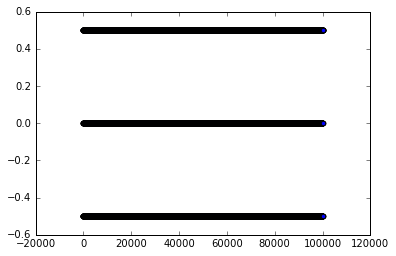

In [66]:
plt.scatter(df.index[0:100000], df['technical_22'][0:100000])
plt.show()

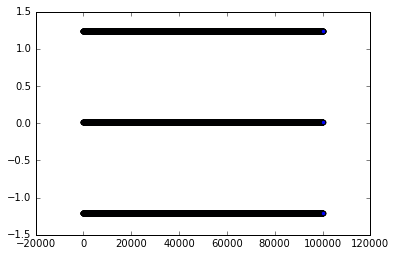

In [168]:
plt.scatter(scaled_df.index[0:100000], scaled_df['technical_22'][0:100000])
plt.show()

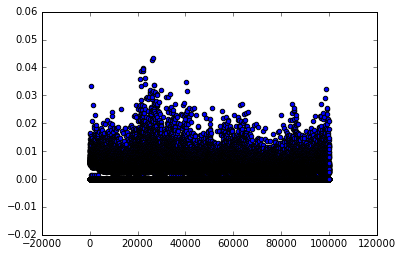

In [67]:
plt.scatter(df.index[0:100000], df['technical_20'][0:100000])
plt.show()

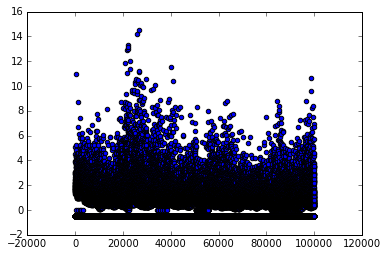

In [169]:
plt.scatter(scaled_df.index[0:100000], scaled_df['technical_20'][0:100000])
plt.show()

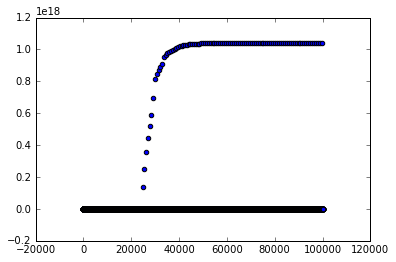

In [111]:
plt.scatter(df.index[0:100000], df['fundamental_17'][0:100000])
plt.show()

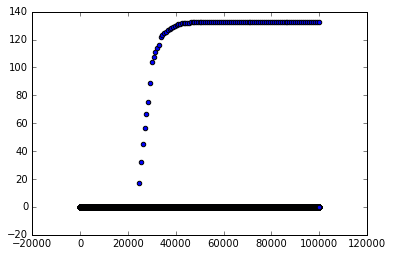

In [170]:
plt.scatter(scaled_df.index[0:100000], scaled_df['fundamental_17'][0:100000])
plt.show()

In [132]:
df.loc[df['fundamental_17']<-100]

,id,timestamp,derived_0,derived_1,derived_3,fundamental_0,fundamental_7,fundamental_10,fundamental_12,fundamental_17,...,technical_36,technical_37,technical_38,technical_39,technical_40,technical_41,technical_42,technical_43,technical_44,y
710,2054,0,-3.489565,7.729436e+11,-0.504601,0.446717,0.955159,0.277591,61.683414,-2.750482e+02,...,-0.968794,-9.103397e-02,-8.156685e-02,-7.287001e-02,1.174601,0.005236,-1.699966e-02,0.000000,0.000388,-0.084104
1460,2054,1,-3.489565,7.729436e+11,-0.504601,0.465502,1.049961,0.215552,61.683414,-2.750482e+02,...,-1.012826,-9.103397e-02,-8.156685e-02,-7.287001e-02,1.189662,0.005236,-1.699966e-02,0.000000,0.000388,-0.048330
2210,2054,2,-3.489565,7.729436e+11,-0.504601,0.472986,1.087732,0.190835,61.683414,-2.750482e+02,...,-1.030368,-9.103397e-02,-8.156685e-02,-7.287001e-02,1.195663,0.005236,-1.699966e-02,0.000000,0.000388,-0.055317
2960,2054,3,-3.489565,7.729436e+11,-0.504601,0.479444,1.120319,0.169509,61.683414,-2.750482e+02,...,-1.045504,-9.103397e-02,-8.156685e-02,-7.287001e-02,1.200840,0.005236,-1.699966e-02,0.000000,0.000388,-0.041373
3710,2054,4,-3.489565,7.729436e+11,-0.504601,0.489844,1.172809,0.135160,61.683414,-2.750482e+02,...,-1.069883,-9.103397e-02,-8.156685e-02,-7.287001e-02,1.209180,0.005236,-1.699966e-02,0.000000,0.000388,-0.026339
4460,2054,5,-3.489565,7.729436e+11,-0.504601,0.494018,1.193875,0.121374,61.683414,-2.750482e+02,...,-1.079667,-9.103397e-02,-8.156685e-02,-7.287001e-02,1.212526,0.005236,-1.699966e-02,0.000000,0.000388,0.078317
5210,2054,6,-3.489565,7.729436e+11,-0.504601,0.497634,1.212121,0.109434,61.683414,-2.750482e+02,...,-1.088141,-9.103397e-02,-8.156685e-02,-7.287001e-02,1.215425,0.005236,-1.699966e-02,0.000000,0.000388,-0.086094
5960,2054,7,-3.489565,7.729436e+11,-0.504601,0.500767,1.227934,0.099085,61.683414,-2.750482e+02,...,-1.095486,-9.103397e-02,-8.156685e-02,-7.287001e-02,1.217937,0.005236,-1.699966e-02,0.000000,0.000388,0.027056
6710,2054,8,-3.489565,7.729436e+11,-0.504601,0.503485,1.241649,0.090110,61.683414,-2.750482e+02,...,-1.101855,-9.103397e-02,-8.156685e-02,-7.287001e-02,1.220116,0.005236,-1.699966e-02,0.000000,0.000388,-0.035502
7460,2054,9,-3.489565,7.729436e+11,-0.504601,0.505843,1.253548,0.082323,61.683414,-2.750482e+02,...,-1.107382,-9.103397e-02,-8.156685e-02,-7.287001e-02,1.222007,0.005236,-1.699966e-02,0.000000,0.000388,-0.007814


In [171]:
scaled_df.loc[df['fundamental_17']<-100]

,derived_0,derived_1,derived_3,fundamental_0,fundamental_7,fundamental_10,fundamental_12,fundamental_17,fundamental_18,fundamental_19,...,technical_35,technical_36,technical_37,technical_38,technical_39,technical_40,technical_41,technical_42,technical_43,technical_44
710,0.004288,-8.884580e-10,0.000001,1.884280,-0.010110,-0.039200,-0.000017,-0.009055,-0.156457,0.817494,...,-1.508656,-1.441606,0.000203,0.000185,0.000136,3.626908,-8.981371e-07,0.000009,1.012717,-2.523474e-07
1460,0.004288,-8.884580e-10,0.000001,1.960054,-0.010090,-0.053997,-0.000017,-0.009055,-0.170325,0.817494,...,-1.605381,-1.513497,0.000203,0.000185,0.000136,3.675443,-8.981371e-07,0.000009,1.012717,-2.523474e-07
2210,0.004288,-8.884580e-10,0.000001,1.990243,-0.010082,-0.059893,-0.000017,-0.009055,-0.175850,0.817494,...,-1.643918,-1.542139,0.000203,0.000185,0.000136,3.694780,-8.981371e-07,0.000009,1.012717,-2.523474e-07
2960,0.004288,-8.884580e-10,0.000001,2.016290,-0.010075,-0.064979,-0.000017,-0.009055,-0.180617,0.817494,...,-1.677166,-1.566851,0.000203,0.000185,0.000136,3.711463,-8.981371e-07,0.000009,1.012717,-2.523474e-07
3710,0.004288,-8.884580e-10,0.000001,2.058244,-0.010064,-0.073172,-0.000017,-0.009055,-0.188295,0.817494,...,-1.730721,-1.606655,0.000203,0.000185,0.000136,3.738335,-8.981371e-07,0.000009,1.012717,-2.523474e-07
4460,0.004288,-8.884580e-10,0.000001,2.075082,-0.010059,-0.076460,-0.000017,-0.009055,-0.191377,0.817494,...,-1.752214,-1.622629,0.000203,0.000185,0.000136,3.749120,-8.981371e-07,0.000009,1.012717,-2.523474e-07
5210,0.004288,-8.884580e-10,0.000001,2.089665,-0.010056,-0.079308,-0.000017,-0.009055,-0.194046,0.817494,...,-1.770830,-1.636465,0.000203,0.000185,0.000136,3.758461,-8.981371e-07,0.000009,1.012717,-2.523474e-07
5960,0.004288,-8.884580e-10,0.000001,2.102305,-0.010052,-0.081776,-0.000017,-0.009055,-0.196359,0.817494,...,-1.786964,-1.648457,0.000203,0.000185,0.000136,3.766557,-8.981371e-07,0.000009,1.012717,-2.523474e-07
6710,0.004288,-8.884580e-10,0.000001,2.113267,-0.010049,-0.083916,-0.000017,-0.009055,-0.198365,0.817494,...,-1.800957,-1.658857,0.000203,0.000185,0.000136,3.773578,-8.981371e-07,0.000009,1.012717,-2.523474e-07
7460,0.004288,-8.884580e-10,0.000001,2.122777,-0.010047,-0.085774,-0.000017,-0.009055,-0.200105,0.817494,...,-1.813097,-1.667881,0.000203,0.000185,0.000136,3.779670,-8.981371e-07,0.000009,1.012717,-2.523474e-07


In [172]:
for c in scaled_df.columns:
    print c,'\t',max(scaled_df[c]),'\t',min(scaled_df[c])

derived_0 	13.3270667713 	-82.5321910861
derived_1 	143.633358093 	-0.0103915716115
derived_3 	12.7174472454 	-352.135331837
fundamental_0 	5.64162778682 	-9.37663807228
fundamental_7 	110.448854055 	-0.0103836486015
fundamental_10 	82.2769019408 	-0.125569859743
fundamental_12 	44.5013209887 	-0.0296633732459
fundamental_17 	132.893569121 	-4.6555394532
fundamental_18 	3.96402444372 	-135.110779399
fundamental_19 	91.8019584523 	-0.214173014908
fundamental_20 	6.92334536171 	-201.423990397
fundamental_21 	10.7293122782 	-6.20371256015
fundamental_25 	126.263618528 	-0.166167965615
fundamental_27 	60.3533077538 	-0.0447331095775
fundamental_32 	44.2055123745 	-0.674225246104
fundamental_33 	93.1228175281 	-0.011396126791
fundamental_36 	114.710236856 	-0.567160658389
fundamental_40 	2.6879950223 	-1.88391950271
fundamental_41 	77.1125398414 	-332.084739882
fundamental_42 	58.8900396768 	-253.615394068
fundamental_45 	201.424136462 	-6.9230607601
fundamental_48 	199.505711505 	-288.4296

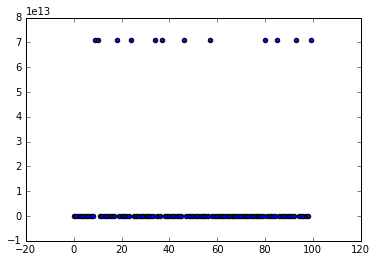

In [113]:
plt.scatter(df.index[0:100], df['fundamental_17'][0:100])
plt.show()

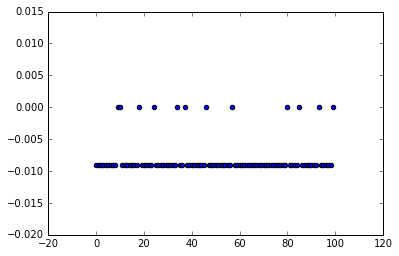

In [173]:
plt.scatter(scaled_df.index[0:100], scaled_df['fundamental_17'][0:100])
plt.show()

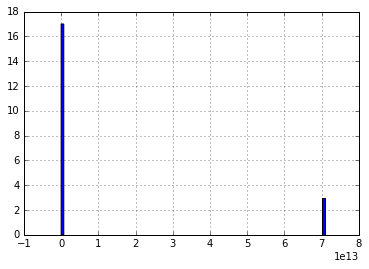

In [125]:
df['fundamental_17'][0:20].hist(bins=100)

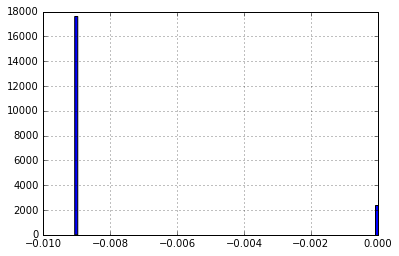

In [175]:
scaled_df['fundamental_17'][0:20000].hist(bins=100)

In [126]:
df['fundamental_17'][0:20]

0    -2.128879e-01
1     2.759483e-02
2    -7.521908e-03
3    -4.449305e-01
4    -3.366069e-02
5    -6.435785e+00
6     2.854674e-01
7     1.353951e-01
8     5.490666e-02
9     7.087444e+13
10    7.087444e+13
11    8.090935e-01
12    4.831248e-02
13   -6.133667e+00
14   -5.282686e-02
15   -2.220099e-01
16   -3.724188e-02
17    7.329962e-01
18    7.087444e+13
19   -4.518610e-01
Name: fundamental_17, dtype: float32

In [176]:
scaled_df['fundamental_17'][0:20]

0    -9.054777e-03
1    -9.054777e-03
2    -9.054777e-03
3    -9.054777e-03
4    -9.054777e-03
5    -9.054777e-03
6    -9.054777e-03
7    -9.054777e-03
8    -9.054777e-03
9    -9.039483e-08
10   -9.039483e-08
11   -9.054777e-03
12   -9.054777e-03
13   -9.054777e-03
14   -9.054777e-03
15   -9.054777e-03
16   -9.054777e-03
17   -9.054777e-03
18   -9.039483e-08
19   -9.054777e-03
Name: fundamental_17, dtype: float64

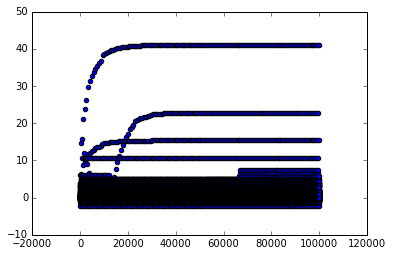

In [68]:
plt.scatter(df.index[0:100000], df['fundamental_19'][0:100000])
plt.show()

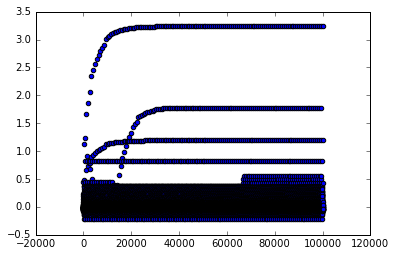

In [177]:
plt.scatter(scaled_df.index[0:100000], scaled_df['fundamental_19'][0:100000])
plt.show()

In [69]:
log_data = np.log(df['fundamental_19']).copy()

In [72]:
df['fundamental_19'].describe()

count    1.710756e+06
mean     3.987797e-01
std      1.253887e+01
min     -2.287757e+00
25%     -9.843951e-02
50%      2.842021e-02
75%      2.913517e-01
max      1.152071e+03
Name: fundamental_19, dtype: float64

In [70]:
log_data.describe()

count    933254.000000
mean         -1.530011
std           1.476514
min         -16.901348
25%          -2.359017
50%          -1.395217
75%          -0.685314
max           7.049316
Name: fundamental_19, dtype: float64

In [74]:
log_data.index

Int64Index([      0,       1,       2,       3,       4,       5,       6,
                  7,       8,       9,
            ...
            1710746, 1710747, 1710748, 1710749, 1710750, 1710751, 1710752,
            1710753, 1710754, 1710755],
           dtype='int64', length=1710756)

In [78]:
len(log_data)

1710756

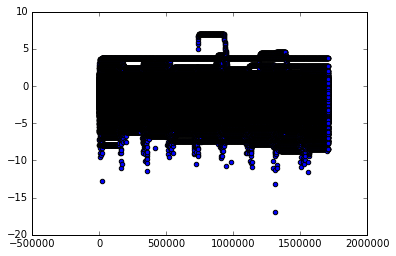

In [79]:
plt.scatter(log_data.index, log_data)
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7faa206ee310>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fa9ca004a90>]], dtype=object)

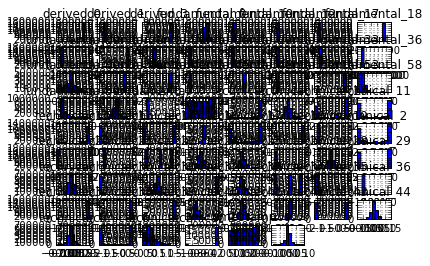

In [81]:
# DataFrame.hist(data, column=None, by=None, grid=True, 
# xlabelsize=None, xrot=None, ylabelsize=None, yrot=None, ax=None, 
# sharex=False, sharey=False, figsize=None, layout=None, bins=10, **kwds)

df.hist()

In [82]:
from sklearn.decomposition import PCA
pca = PCA(n_components=6)
pca.fit(df)

PCA(copy=True, n_components=6, whiten=False)

In [83]:
print(pca.explained_variance_ratio_) 
print(np.sum(pca.explained_variance_ratio_[0:2])) 
print(np.sum(pca.explained_variance_ratio_[0:4])) 

[  9.99909669e-01   9.03311705e-05   2.35677170e-14   8.23568751e-15
   4.91085984e-15   3.55186831e-15]
1.0
1.0


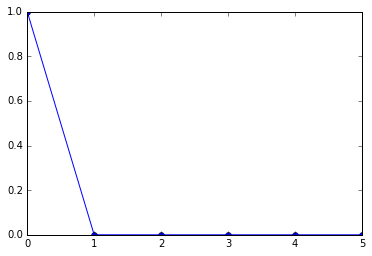

In [93]:
#plt.scatter([0,1,2,3,4,5],pca.explained_variance_ratio_)
plt.plot([0,1,2,3,4,5],pca.explained_variance_ratio_, '-o')
plt.show()

In [ ]:
#clearly only one component is relevant

In [96]:
# Fit PCA to the df using only one dimensions
pca = PCA(n_components=1)
pca.fit(df)

# Apply PCA transformation on df to get reduced_df
reduced_df = pca.transform(df)

# Create a DataFrame for the reduced data
reduced_df = pd.DataFrame(reduced_df, columns = ['Dimension 1'])

In [109]:
pca.components_[0]

array([ -6.43899989e-10,  -1.78813934e-07,   0.00000000e+00,
        -8.76499712e-07,   2.16398306e-18,   6.05598107e-19,
        -5.68944222e-17,  -4.32987201e-19,  -6.82485217e-17,
         1.00000000e+00,   8.16667199e-19,   4.27392816e-20,
         1.40421953e-18,   5.19475008e-19,   2.41984176e-20,
        -4.23484875e-18,  -3.69618741e-17,  -7.04369306e-16,
        -2.85206052e-17,  -2.77493091e-19,   9.19124027e-16,
         3.11540200e-16,  -1.41901686e-18,  -1.29023800e-19,
        -4.66519681e-19,  -2.21305271e-19,  -1.38220833e-19,
         1.93963255e-19,   4.44440111e-19,   1.22308127e-19,
        -4.48341909e-21,  -7.96105893e-20,  -2.16676229e-20,
         8.75943778e-22,  -3.30236608e-20,   1.99474592e-19,
         2.54453439e-20,   5.31767688e-19,  -1.25802461e-19,
        -1.83378794e-19,  -8.89986562e-23,  -1.19068048e-18,
         1.14110242e-21,  -8.03892829e-20,  -1.49304446e-19,
         1.52437096e-19,   2.30801445e-21,   3.55208881e-19,
         6.20506176e-19,

In [110]:
df.columns

Index([u'id', u'timestamp', u'derived_0', u'derived_1', u'derived_3',
       u'fundamental_0', u'fundamental_7', u'fundamental_10',
       u'fundamental_12', u'fundamental_17', u'fundamental_18',
       u'fundamental_19', u'fundamental_20', u'fundamental_21',
       u'fundamental_25', u'fundamental_27', u'fundamental_32',
       u'fundamental_33', u'fundamental_36', u'fundamental_40',
       u'fundamental_41', u'fundamental_42', u'fundamental_45',
       u'fundamental_48', u'fundamental_52', u'fundamental_53',
       u'fundamental_58', u'fundamental_59', u'fundamental_62', u'technical_0',
       u'technical_1', u'technical_2', u'technical_3', u'technical_5',
       u'technical_6', u'technical_7', u'technical_9', u'technical_10',
       u'technical_11', u'technical_12', u'technical_13', u'technical_14',
       u'technical_16', u'technical_17', u'technical_18', u'technical_19',
       u'technical_20', u'technical_21', u'technical_22', u'technical_24',
       u'technical_25', u'technical_

In [98]:
reduced_df.describe()

,Dimension 1
count,1.710756e+06
mean,4.290404e+11
std,7.827103e+15
min,-3.644066e+16
25%,-7.087516e+13
50%,-7.087516e+13
75%,-7.087516e+13
max,1.040208e+18


In [191]:
from sklearn.decomposition import PCA
scaled_pca = PCA(n_components=50)
scaled_pca.fit(scaled_df)

PCA(copy=True, n_components=50, whiten=False)

In [192]:
print(scaled_pca.explained_variance_ratio_) 

[ 0.09087867  0.05314797  0.05220472  0.04383628  0.0300508   0.02925
  0.02788247  0.02537582  0.0235675   0.02271828  0.01989215  0.01954053
  0.01857655  0.01788866  0.01652193  0.01638901  0.01553247  0.01540897
  0.01528124  0.0152264   0.0151397   0.0150923   0.01502981  0.01500341
  0.01499106  0.01494102  0.01492142  0.01487993  0.01485638  0.0148178
  0.01473759  0.01463354  0.01458156  0.01441166  0.01439617  0.01422811
  0.01377199  0.0121712   0.01190735  0.01016522  0.0098955   0.00898221
  0.00881687  0.00858895  0.00829203  0.00791822  0.00781477  0.00714551
  0.0069752   0.0066768 ]


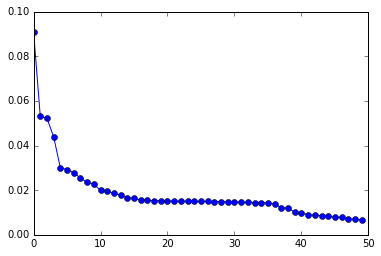

In [193]:
#plt.scatter([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],pca.explained_variance_ratio_)
plt.plot(range(50),scaled_pca.explained_variance_ratio_, '-o')
plt.show()

In [195]:
scaled_df.describe()

,derived_0,derived_1,derived_3,fundamental_0,fundamental_7,fundamental_10,fundamental_12,fundamental_17,fundamental_18,fundamental_19,...,technical_35,technical_36,technical_37,technical_38,technical_39,technical_40,technical_41,technical_42,technical_43,technical_44
count,1.710756e+06,1.710756e+06,1.710756e+06,1.710756e+06,1.710756e+06,1.710756e+06,1.710756e+06,1.710756e+06,1.710756e+06,1.710756e+06,...,1.710756e+06,1.710756e+06,1.710756e+06,1.710756e+06,1.710756e+06,1.710756e+06,1.710756e+06,1.710756e+06,1.710756e+06,1.710756e+06
mean,2.555606e-16,-4.976259e-14,5.008116e-15,8.680545e-16,-1.164706e-14,-2.803573e-14,-1.497526e-14,2.366561e-13,-8.122068e-16,-9.348821e-15,...,1.395497e-14,7.898375e-15,5.411966e-14,1.854525e-13,2.480608e-13,2.012980e-14,7.109583e-16,-4.381431e-13,-1.048588e-13,1.155690e-14
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-8.253219e+01,-1.039157e-02,-3.521353e+02,-9.376638e+00,-1.038365e-02,-1.255699e-01,-2.966337e-02,-4.655539e+00,-1.351108e+02,-2.141730e-01,...,-2.311377e+00,-2.615164e+00,-3.690213e+00,-3.957369e+00,-4.181026e+00,-1.850199e+00,-4.020812e+00,-4.661203e+00,-1.067715e+00,-4.538786e+00
25%,1.780963e-02,-1.039157e-02,2.445865e-03,-7.121557e-01,-1.033651e-02,-1.134816e-01,-2.965799e-02,-9.054777e-03,4.817216e-02,-3.965835e-02,...,-5.804102e-01,-5.200795e-01,3.665983e-01,3.503363e-01,3.285692e-01,-6.478286e-01,-6.863147e-01,8.061787e-02,-1.067715e+00,-5.996222e-01
50%,1.852847e-02,-1.039157e-02,4.942854e-03,-6.577885e-02,-1.030784e-02,-9.898097e-02,-2.964321e-02,-9.054777e-03,6.492417e-02,-2.954612e-02,...,-1.363848e-02,-8.912251e-06,3.698028e-01,3.516587e-01,3.287648e-01,-2.043559e-01,-1.250241e-02,8.061787e-02,3.048584e-01,-2.523474e-07
75%,1.902801e-02,-1.039157e-02,7.836517e-03,5.962066e-01,-1.026771e-02,-4.638761e-02,-2.956250e-02,-9.054777e-03,7.906783e-02,-8.587349e-03,...,4.744301e-01,4.509751e-01,3.698028e-01,3.516587e-01,3.287648e-01,4.116002e-01,6.326445e-01,8.061787e-02,1.012717e+00,5.869617e-01
max,1.332707e+01,1.436334e+02,1.271745e+01,5.641628e+00,1.104489e+02,8.227690e+01,4.450132e+01,1.328936e+02,3.964024e+00,9.180196e+01,...,2.671111e+01,8.108612e+01,3.698028e-01,3.516587e-01,3.287648e-01,4.898680e+00,6.066615e+00,4.822439e+00,1.012717e+00,5.119408e+00


In [209]:
print(np.sum(scaled_pca.explained_variance_ratio_[0:2])) 
print(np.sum(scaled_pca.explained_variance_ratio_[0:4])) 
print(np.sum(scaled_pca.explained_variance_ratio_[0:25]))
print(np.sum(scaled_pca.explained_variance_ratio_[0:30]))
print(np.sum(scaled_pca.explained_variance_ratio_[0:40]))
print(np.sum(scaled_pca.explained_variance_ratio_))

0.144026637842
0.240067641891
0.644426684073
0.718843235639
0.853847618782
0.934953691107


In [187]:
# Fit PCA to the df using only one dimensions
pca = PCA(n_components=1)
pca.fit(df)

# Apply PCA transformation on df to get reduced_df
reduced_df = pca.transform(df)

# Create a DataFrame for the reduced data
reduced_df = pd.DataFrame(reduced_df, columns = ['Dimension 1'])

In [206]:
reduced_df_small=reduced_df[0:50000]

n_clusters: 4 , score: 0.9998
n_clusters: 3 , score: 0.9998
n_clusters: 2 , score: 0.9998


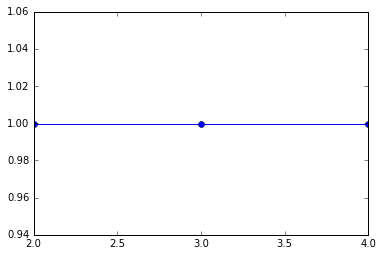

In [207]:
# Apply kmeans clustering algorithm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
sil_scores = []

for i in range(4,1,-1):
    clusterer = KMeans(n_clusters = i, random_state = 31)
    # est.fit(X)
    # labels = est.labels_
    # Predict the cluster for each data point
    preds = clusterer.fit_predict(reduced_df_small)

    # Find the cluster centers
    centers = clusterer.cluster_centers_

    # Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(reduced_df_small, preds)
    score = score.round(4)
    sil_scores.append(score)
    print "n_clusters:",i,", score:", score

# plot the scores
_ = plt.plot(np.arange(4,1,-1), sil_scores, '-o')


In [211]:
# Fit PCA to the df using only one dimensions
pca_scaled = PCA(n_components=50)
pca_scaled.fit(scaled_df)

# Apply PCA transformation on df to get reduced_df
reduced_scaled_df = pca_scaled.transform(scaled_df)

# Create a DataFrame for the reduced data
reduced_scaled_df = pd.DataFrame(reduced_scaled_df)

In [214]:
reduced_scaled_df_small=reduced_scaled_df[0:5000]

n_clusters: 5 , score: 0.2125
n_clusters: 4 , score: 0.2072
n_clusters: 3 , score: 0.2879
n_clusters: 2 , score: 0.9572


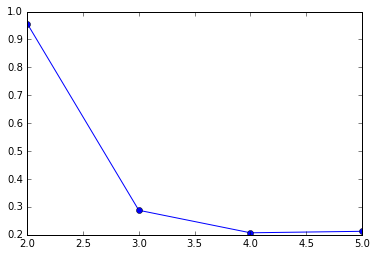

In [216]:
# Apply kmeans clustering algorithm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
sil_scores = []

for i in range(5,1,-1):
    clusterer = KMeans(n_clusters = i, random_state = 31)
    # est.fit(X)
    # labels = est.labels_
    # Predict the cluster for each data point
    preds = clusterer.fit_predict(reduced_scaled_df_small)

    # Find the cluster centers
    centers = clusterer.cluster_centers_

    # Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(reduced_scaled_df_small, preds)
    score = score.round(4)
    sil_scores.append(score)
    print "n_clusters:",i,", score:", score

# plot the scores
_ = plt.plot(np.arange(5,1,-1), sil_scores, '-o')


In [ ]:
In [5]: df = DataFrame(randn(1000, 4), index=ts.index, columns=list('ABCD'))

In [6]: df = df.cumsum()

In [7]: plt.figure(); df.plot();

In [16]:
# explore small portion of dataset
# timestamp 0 and 1
ndf = df[['id','timestamp','derived_0','derived_1','derived_2','derived_3','derived_4','y']]
ndf.describe()

,id,timestamp,derived_0,derived_1,derived_2,derived_3,derived_4,y
count,1.710756e+06,1.710756e+06,1.637797e+06,1.629727e+06,1.312105e+06,1.561285e+06,1.304298e+06,1.710756e+06
mean,1.093858e+03,9.456257e+02,-4.536046e+00,7.729436e+11,-3.320328e-01,-5.046012e-01,1.801661e+01,2.217509e-04
std,6.308563e+02,5.195685e+02,2.497382e+02,7.620606e+13,6.519810e+01,1.020749e+02,9.258360e+02,2.240643e-02
min,0.000000e+00,0.000000e+00,-2.017497e+04,-7.375435e-02,-9.848880e+03,-3.434176e+04,-8.551914e+03,-8.609413e-02
25%,5.500000e+02,5.040000e+02,-1.449710e-01,-2.956479e-02,-5.967524e-02,-1.655826e-01,-1.057050e-01,-9.561389e-03
50%,1.098000e+03,9.560000e+02,-8.368272e-04,5.523058e-03,2.109505e-02,2.475614e-03,1.175234e-02,-1.570681e-04
75%,1.657000e+03,1.401000e+03,1.199108e-01,1.078554e-01,1.952209e-01,3.037236e-01,1.556464e-01,9.520990e-03
max,2.158000e+03,1.812000e+03,3.252527e+03,1.068448e+16,3.823001e+03,1.239737e+03,6.785965e+04,9.349781e-02


In [42]:
#ndf.loc[ndf.id==10]
print "number of times security {} is traded: {}".format(10,sum(ndf.id==10))

number of times security 10 is traded: 116


In [47]:
print "number of securities traded at timestamp {} are : {}".format(0,sum(ndf.timestamp==0))
print "number of securities traded at timestamp {} are : {}".format(1,sum(ndf.timestamp==1))
print "number of securities traded at timestamp {} are : {}".format(25,sum(ndf.timestamp==25))

number of securities traded at timestamp 0 are : 750
number of securities traded at timestamp 1 are : 750
number of securities traded at timestamp 25 are : 745


In [45]:
#list securities at timestamp 0
ndf.loc[ndf.timestamp==0]

,id,timestamp,derived_0,derived_1,derived_2,derived_3,derived_4,y
0,10,0,0.370326,-0.006316,0.222831,-0.213030,0.729277,-0.011753
1,11,0,0.014765,-0.038064,-0.017425,0.320652,-0.034134,-0.001240
2,12,0,-0.010622,-0.050577,3.379575,-0.157525,-0.068550,-0.020940
3,25,0,NaN,NaN,NaN,NaN,NaN,-0.015959
4,26,0,0.176693,-0.025284,-0.057680,0.015100,0.180894,-0.007338
5,27,0,0.346856,0.166239,-6.080701,-0.992249,-0.125916,0.031425
6,31,0,0.072036,0.014931,NaN,0.014063,NaN,-0.032895
7,38,0,0.300062,0.071251,-0.074451,-0.065292,-0.011286,0.015803
8,39,0,-0.003511,-0.034270,0.082372,-0.023937,-0.025750,-0.027593
9,40,0,-0.083330,0.081935,-2.048438,-0.206856,-0.839563,0.006662


In [46]:
#list all rows where security 10 data is available in train data 
ndf.loc[ndf.id==10]

,id,timestamp,derived_0,derived_1,derived_2,derived_3,derived_4,y
0,10,0,0.370326,-0.006316,0.222831,-0.213030,0.729277,-0.011753
750,10,1,0.370326,-0.008504,0.224193,-0.216165,0.729277,0.005850
1500,10,2,0.370326,-0.009375,0.224736,-0.217415,0.729277,-0.000476
2250,10,3,0.370326,-0.010127,0.225204,-0.218492,0.729277,0.005212
3000,10,4,0.370326,-0.011338,0.225958,-0.220228,0.729277,-0.077211
3750,10,5,0.370326,-0.011824,0.226261,-0.220925,0.729277,0.006086
4500,10,6,0.370326,-0.012245,0.226523,-0.221528,0.729277,-0.027747
5250,10,7,0.370326,-0.012610,0.226750,-0.222051,0.729277,-0.033304
6000,10,8,0.370326,-0.012926,0.226947,-0.222505,0.729277,-0.002235
6750,10,9,0.370326,-0.013200,0.227118,-0.222898,0.729277,0.067070


In [17]:
range(10)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [27]:
df[['id', 'timestamp']].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000C7B7518>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000000000C7E6F28>]], dtype=object)

In [ ]:
df.plot()